# Import basic libraries

Let's import some basic stuff

## TODO
- Add the nodes in the CityJSON file, keeping the relationships between nodes and edges (linestrings). The nodes have semantics and atttributes.
- Find a small area and compute widths.
- Create LoD0.1 with single lines and attributes for two-way and same for LoD0.2.

# Ideas for modelling

1. Every city object contains `MultiPoints` (nodes of LoD0.1), `MultiLineStrings` (edges of LoD0.1) and `MultiSurfaces `(for LoD1+).
2. Every city object contains `MultiLineStrings` (geometry of edges of LoD0.1) and `MultiSurfaces` (for LoD1+). The network topology (nodes and edges) is defined in its own `"+network"` portion of the city model.
3. Every city object has its own `MultiSurfaces` (for LoD1+). Then the actual network (nodes, edges and their geometry) is stored in `"+network"`.
4. Every node is its own city object. Every edge is its own city object. Every surface is its own city object. Then `CityObjectGroups` are used to relate them.

### Fix for `fiona`

*`fiona` has an issue with GDAL 3.0. Better set your `GDAL_DATA` path to fiona's installation (contains GDAL 2.4.4) prior to running this script.*

In [1]:
import geopandas
import pandas as pd
import osmnx as ox
import networkx as nx
import shapely

# Load the OSM data

This will load the osm file to a network

In [2]:
# We don't want edges to be loaded twice
ox.config(all_oneway=True)

network_graph = ox.graph_from_file('../data/Breda/Breda extract.osm', simplify=False)
# We simplify the graph afterwards, so that osmids are not "smashed" together
network_graph = ox.simplify_graph(network_graph, strict=False)

We create `UUID` for every edge:

In [3]:
import uuid
import hashlib
import json
from cityhash import CityHash32

hashes = []
for u,v,a in network_graph.edges(data=True):
    temp = {
        "osmid": a['osmid'],
        "length": a['length']
    }
    a['uuid'] = CityHash32(uuid.uuid4().hex)
    hashes.append(a['uuid'])

assert len(hashes) == len(set(hashes))

Then we export the edges to a GeoDataFrame:

In [345]:
nodes, edges = ox.graph_to_gdfs(network_graph)

edges = edges.to_crs("EPSG:28992")

len(edges)

9856

In [348]:
nodes.to_file('output/nodes.geojson', driver='GeoJSON')

## Filter drive and service roads only

Filter roads to only motorways:

In [6]:
highway_types = [
    "primary",
    "secondary",
    "motorway",
    "trunk",
    "tertiary",
    "unclassified",
    "residential",

    "motorway_link",
    "trunk_link",
    "primary_link",
    "secondary_link",
    "tertiary_link",

    "living_street",
    "service",
    "pedestrian",
    "track",
    "bus_guideway",
    "escape",
    "raceway",
    "road"
]

road_edges = edges[(edges['highway'].isin(highway_types)) & (edges['area'] != 'yes')]

road_edges.to_file('output/road_edges.geojson', driver='GeoJSON')
len(road_edges)

685

In [7]:
road_edges.head()

,u,v,key,osmid,name,area,highway,length,uuid,geometry,oneway,maxspeed,landuse,access,bridge,tunnel,service,lanes,ref,width
52,6450151604,43136448,0,7224397,Keizerstraat,NaN,tertiary,10.281,3206435346,"LINESTRING (112852.058 399899.616, 112851.205 ...",yes,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,43155685,4454022829,0,7225340,NaN,NaN,service,8.436,4209164125,"LINESTRING (112517.886 400392.439, 112520.296 ...",NaN,NaN,NaN,no,yes,NaN,NaN,NaN,NaN,NaN
99,1642954984,2197761851,0,7224390,Kloosterplein,NaN,tertiary,5.654,3383959076,"LINESTRING (112993.855 400056.230, 112999.227 ...",yes,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,1642954984,43142237,0,7224394,Vlaszak,NaN,tertiary,8.249,1100907897,"LINESTRING (112993.855 400056.230, 112994.962 ...",yes,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,1401651638,2731824407,0,126447044,Sint Janstraat,NaN,pedestrian,7.449,4047054856,"LINESTRING (112787.440 400066.830, 112783.461 ...",NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,NaN


# Load the BGT data

In [8]:
bgt_roads = geopandas.read_file('../data/Breda/bgt_roads.geojson')

len(bgt_roads)

38859

## Compute primary-secondary road polygons

We need to assign secondary road polygons (parking spaces, sidewalks) to the primary roads

### Filter primary roads

Primary types are those that vehicles are supposed to move:

In [9]:
bgt_road_types = [
    'rijbaan lokale weg',
    'rijbaan regionale weg',
    # 'overweg' # Maybe?
]

bgt_roads =  bgt_roads[bgt_roads['eindRegistratie'].isnull()]

bgt_roads['parent_gml_id'] = bgt_roads['gml_id']

bgt_main_roads = bgt_roads[bgt_roads['function'].isin(bgt_road_types)]

len(bgt_main_roads)

6899

### Identify parent for every secondary road

Find the secondary roads that touch the main ones:

In [10]:
bgt_secondary_roads = bgt_roads[~bgt_roads['function'].isin(bgt_road_types)]

len(bgt_secondary_roads)

19551

Let's overlay the secondary roads with the main roads. The result should be (mostly) linestrings accross their common boundaries:

In [12]:
bgt_common_boundaries = geopandas.overlay(bgt_secondary_roads, bgt_main_roads, how='intersection', keep_geom_type=False)

len(bgt_common_boundaries)

29544

We need to compute the longest common boundary per `gml_id` to pick the respective parent `gml_id`:

In [13]:
bgt_common_boundaries['length'] = bgt_common_boundaries['geometry'].length

max_rows = bgt_common_boundaries[['gml_id_1', 'function_1', 'gml_id_2', 'geometry', 'length']].groupby('gml_id_1')['length'].idxmax()

Now, let's join this with the original secondary rows table to bring back their original geometries:

In [14]:
temp_roads = bgt_common_boundaries.loc[max_rows]
temp_roads = temp_roads[['gml_id_1', 'function_1', 'gml_id_2', 'geometry']]
temp_roads = temp_roads.rename(columns={'gml_id_1': 'gml_id', 'function_1': 'function', 'gml_id_2': 'parent_gml_id'})
temp_roads = temp_roads.set_index('gml_id')

bgt_roads_parented = temp_roads.merge(bgt_secondary_roads.set_index('gml_id'), on='gml_id', suffixes=('', '_right'))
bgt_roads_parented = bgt_roads_parented[['function', 'parent_gml_id', 'geometry_right']].rename(columns={'geometry_right': 'geometry'})
bgt_roads_parented = bgt_roads_parented.reset_index()

bgt_roads_parented = geopandas.GeoDataFrame(bgt_roads_parented, crs='EPSG:28992')

len(bgt_roads_parented)

14235

### Merge primary and secondary roads

Concatenate everything:

In [15]:
bgt_all_roads = pd.concat([bgt_roads_parented, bgt_main_roads[['gml_id', 'function', 'parent_gml_id', 'geometry']]])

bgt_all_roads.to_file('output/bgt_all_roads.geojson', driver='GeoJSON')

len(bgt_all_roads)

21134

# Intersect roads network with polygon
First, we intersect the road lines with the BGT polygons (to create nodes at the polygon boundaries):

In [16]:
roads = geopandas.overlay(road_edges, bgt_all_roads, how='intersection')

Export the intersected roads to `GeoJSON`:

In [17]:
roads.to_file('output/roads.json', driver='GeoJSON')

roads.head()

,u,v,key,osmid,name,area,highway,length,uuid,oneway,...,bridge,tunnel,service,lanes,ref,width,gml_id,function,parent_gml_id,geometry
0,6450151604,43136448,0,7224397,Keizerstraat,NaN,tertiary,10.281,3206435346,yes,...,NaN,NaN,NaN,NaN,NaN,NaN,b7242fa64-c535-4445-be1c-7bfbe7f9564f,fietspad,bebfd7ae6-7fd0-4d2a-b300-ba3b13525b4d,"LINESTRING (112850.872 399908.820, 112850.743 ..."
1,43136448,43136804,0,7224397,Keizerstraat,NaN,tertiary,13.041,2558797229,yes,...,NaN,NaN,NaN,NaN,NaN,NaN,b7242fa64-c535-4445-be1c-7bfbe7f9564f,fietspad,bebfd7ae6-7fd0-4d2a-b300-ba3b13525b4d,"LINESTRING (112850.743 399909.818, 112850.605 ..."
2,6450151604,43136448,0,7224397,Keizerstraat,NaN,tertiary,10.281,3206435346,yes,...,NaN,NaN,NaN,NaN,NaN,NaN,b1f4910c2-00c3-4fce-856a-847a5e337f16,rijbaan lokale weg,b1f4910c2-00c3-4fce-856a-847a5e337f16,"LINESTRING (112852.058 399899.616, 112851.205 ..."
3,43132022,6450151604,0,7224415,Keizerstraat,NaN,tertiary,82.845,518123154,yes,...,NaN,NaN,NaN,NaN,NaN,NaN,b1f4910c2-00c3-4fce-856a-847a5e337f16,rijbaan lokale weg,b1f4910c2-00c3-4fce-856a-847a5e337f16,"LINESTRING (112857.519 399822.959, 112858.531 ..."
4,43155685,4454022829,0,7225340,NaN,NaN,service,8.436,4209164125,NaN,...,yes,NaN,NaN,NaN,NaN,NaN,b7bfd8ed3-cf75-40ac-9af4-7b06596a7879,rijbaan lokale weg,b7bfd8ed3-cf75-40ac-9af4-7b06596a7879,"LINESTRING (112517.886 400392.439, 112520.230 ..."


# Export to CityJSON

Let's export everything to CityJSON.

First, we'll define how the established intersected lines will be translated to `Road` objects:

In [18]:
def process_ring(line, vertices):
    """Returns the boundaries array of a single linear rings.
    
    Arguments:
    line -- The LineString to be processed (represents the ring)
    vertices -- the global vertices list of the CityJSON
    """
    points = [[x, y, 0] for x, y in list(line.coords)]
    indices = [i + len(vertices) for i in range(len(points))]
    for p in points:
        vertices.append(p)

    return indices

def process_linestring(geom, vertices):
    """Returns the boundaries array of a linear element.
    
    This can process LineString or MultiLineString geometries.
    
    Arguments:
    geom -- the (linear) geometry to be processed
    vertices -- the global vertices list of the CityJSON
    """
    if geom.type == "LineString":
        indices = [process_ring(geom, vertices)]
    else:
        indices = []
        
        for l in geom.geoms:
            indices.append(process_ring(l, vertices))
        
    return indices

def create_geometry(geom, lod, vertices):
    """Returns a CityJSON geometry from a single shapely geometry.
    
    This will also append the 'vertices' list with new vertices.
    
    Arguments:
    geom -- the shapely geometry to be processed
    lod -- the lod of the resulting CityJSON geometry
    vertices -- the global vertices list of the CityJSON
    """
    indices = []
    
    if geom.type == "LineString" or geom.type == "MultiLineString":
        geom_type = "MultiLineString"
        
        indices = process_linestring(geom, vertices)
    elif geom.type == "Polygon":
        geom_type = "MultiSurface"
        
        indices = [process_linestring(geom.boundary, vertices)]
    else:
        raise TypeError(geom.type)
    
    return {
        "type": geom_type,
        "lod": lod,
        "boundaries": indices
    }

def create_geom_with_semantics(map_func, features, lod, vertices, geom_column='geometry'):
    """Returns a CityJSON geometry with semantic elements from multiple features.
    
    Semantic elements are semantic lines (for LineString) or surfaces (for
    MultiSurface).
    
    Arguments:
    map_func -- function that maps an input feature to an output semantic element
    features -- list of features to be processed
    lod -- the lod of the resulting CityJSON geometry
    vertices -- the global vertices list of the CityJSON
    """
    boundaries = []
    semantics = {
        "surfaces": [],
        "values": []
    }
    
    # Get the resulting geometry type from the first feature
    geom = features[0][geom_column]
    if geom.type == "LineString" or geom.type == "MultiLineString":
        geom_type = "MultiLineString"
    elif geom.type == "Polygon":
        geom_type = "MultiSurface"
    else:
        raise TypeError(geom.type)
    
    # Process all features
    i = 0
    for f in features:
        surface = map_func(f)
        
        if geom_type == "MultiLineString":
            indices = process_linestring(f[geom_column], vertices)
            for l in indices:
                boundaries.append(l)
                semantics["surfaces"].append(surface)
                semantics["values"].append(i)
                i = i + 1
        else:
            indices = process_linestring(f[geom_column].boundary, vertices)
        
            boundaries.append(indices)
            semantics["surfaces"].append(surface)
            semantics["values"].append(i)
            i = i + 1
    
    return {
        "type": geom_type,
        "lod": lod,
        "boundaries": boundaries,
        "semantics": semantics
    }

def osm_semantics_map(feature):
    obj = {
        "type": feature['highway'],
        "osm_id": feature['osmid'],
        "oneway": feature['oneway'] if isinstance(feature['oneway'], str) else "no"
    }
    
    if isinstance(feature['name'], str):
        obj["name"] = feature['name']
    
    if isinstance(feature['maxspeed'], str):
        obj["maxspeed"] = feature['maxspeed']
    
    return obj

def bgt_semantics_map(feature):
    return {
        "type": feature['function'],
        "gml_id": feature['gml_id']
    }

def create_cityobject(feature, vertices):
    """Create a CityJSON city object from a single OSM linear features."""
    return {
        "type": "Road",
        "attributes": {
            "osm_id": feature['osmid'],
            "highway": feature['highway'],
        },
        "geometry": [
            create_geometry(feature['geometry'], "0.1", vertices)
        ]
    }

Now, let's run this against all intersected road segments:

In [19]:
vertices = []
objects = {}

road_groups = roads.groupby('parent_gml_id')

for gml_id, group in road_groups:
    features = [f for i, f in group.iterrows()]
    objects[gml_id] = {
        "type": "Road",
        "geometry": [
            create_geom_with_semantics(osm_semantics_map,
                                       features,
                                       '0.1',
                                       vertices)
        ]
    }

bgt_roads_groups = bgt_all_roads.groupby('parent_gml_id')

for main_gml_id, group in bgt_roads_groups:
    if main_gml_id in objects:
        features = [f for i, f in group.iterrows()]
        objects[main_gml_id]['geometry'].append(
            create_geom_with_semantics(bgt_semantics_map,
                                       features,
                                       '2',
                                       vertices)
        )

Finally, let's export everything as CityJSON:

In [20]:
import json
import io

output = {
  "type": "CityJSON",
  "version": "1.0",
  "CityObjects": objects,
  "vertices": vertices
}

with open('output/breda.json', 'w') as file:
    json.dump(output, file)

## Fix missing network and polygons
We should create individual road objects for the polygons (and respective network segments) that do not have a `parent_gml_id`.

# Calculate carriageways and lanes
- Compute the carriageways only from OSM attributes.
- Compute road width:
     - We exclude intersections.
- How we create the carriageways for twoway streets and more specifically for intersections.

NOTE: Case of a two-way road where we figure out that the road width doesn't fit two lanes (special case were two ways share the same carriageway).

In [21]:
from shapely.ops import unary_union
from shapely.geometry import Point, LineString, MultiLineString

def get_vertex(line, first=True):
    """Returns the first or last vertex"""
    if line.type == "LineString":
#         print(len(line.boundary))
        return line.boundary[0 if first else len(line.boundary) - 1]
    elif line.type == "MultiLineString" and len(line.geoms) == 1:
        return line.geoms[0].boundary[0 if first else len(line.boundary) - 1]
    else:
        raise TypeError("This is MultiLineString with many parts!")

## Calculate width

### Using PostGIS

This is to calculate the widths in PostGIS using [this](https://github.com/willemhoffmans/bgt_wegbreedte/).

Let's import stuff and create the connection with the database:

In [22]:
# SO https://gis.stackexchange.com/a/239231

# Imports
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *
import pandas as pd
import geopandas as gpd

pg_user = "roads"
pg_pass = "roads"
pg_host = "localhost"
pg_port = 5432
pg_database = "road_widths"

# Creating SQLAlchemy's engine to use
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(pg_user, pg_pass, pg_host, pg_port, pg_database))

Now we export the BGT roads to the database with the appropriate names:

In [23]:
export_bgt = bgt_roads.copy()
export_bgt['geometrie_vlak'] = export_bgt['geometry'].apply(lambda x: WKTElement(x.wkt, srid=28992))

export_bgt.drop('geometry', 1, inplace=True)

export_bgt = export_bgt.rename(columns={'function':'bgt_functie'})

# Use 'dtype' to specify column's type
# For the geom column, we will use GeoAlchemy's type 'Geometry'
export_bgt.to_sql("wegdeel", engine, schema='bgt', if_exists='replace', index=False, 
                         dtype={'geometrie_vlak': Geometry('POLYGON', srid=28992)})

Let's create the required functions in the database:

In [24]:
import psycopg2

conn = psycopg2.connect(dbname=pg_database, user=pg_user, password=pg_pass)

file = open("wegbreedtes_script.sql", "r")
conn.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_AUTOCOMMIT)
cursor = conn.cursor()
cursor.execute(file.read())

Export the roads:

In [25]:
from shapely.geometry import MultiLineString

export_roads = road_edges.copy()
export_roads['geom'] = export_roads['geometry'].apply(lambda x: WKTElement(MultiLineString([x]).wkt, srid=28992))

export_roads.drop('geometry', 1, inplace=True)

# Use 'dtype' to specify column's type
# For the geom column, we will use GeoAlchemy's type 'Geometry'
export_roads.to_sql("road_edges", engine, if_exists='replace', index=False, 
                         dtype={'geom': Geometry('MULTILINESTRING', srid=28992)})

Now, run the function to compute the widths:

In [26]:
conn = psycopg2.connect(dbname=pg_database, user=pg_user, password=pg_pass)
conn.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_AUTOCOMMIT)

cursor = conn.cursor()

cursor.execute("SELECT wh_wegbreedte_bgt_generiek ('road_edges', 'uuid', false, 0);")
for c in cursor:
    print(c)

('OK!',)


Load the resulting table with widths:

In [27]:
roads_with_width = geopandas.GeoDataFrame.from_postgis("SELECT * FROM breedte_analyse_nieuw.gemiddeldebreedte", conn, geom_col='geom' )

roads_with_width = roads_with_width.rename(columns={"geom": "geometry"})

roads_with_width.head()

,gid,typeweg,wegvakid,geometry,gem_breedte,dev_breedte,min_breedte,max_breedte,oper_breedte,afst_s,aantal,aantal_op
0,546,rijbaan lokale weg,3914420667,"MULTILINESTRING ((113084.624 400210.646, 11307...",5.60,4.56,4.06,17.77,4.08,0.00,9,8
1,1,rijbaan lokale weg,28077830,"MULTILINESTRING ((113184.980 400110.795, 11317...",17.08,2.29,13.45,19.82,17.67,0.00,9,6
2,2,rijbaan lokale weg,42931395,"MULTILINESTRING ((112130.344 399744.057, 11213...",3.66,0.09,3.49,3.76,3.67,0.00,9,7
3,3,rijbaan lokale weg,56554831,"MULTILINESTRING ((113006.409 399752.438, 11299...",4.96,0.07,4.81,5.07,4.97,0.00,9,7
4,4,rijbaan lokale weg,58306695,"MULTILINESTRING ((112163.992 400028.880, 11214...",3.68,0.33,3.51,4.54,3.57,1.13,9,8


# Create carriageways

We calculated the widths via PostGIS using [this](https://github.com/willemhoffmans/bgt_wegbreedte/) (embarassingly, the previous scripts didn't work).

Let's load the data with the width:

In [28]:
roads_width_final_final = roads_with_width.rename(columns={"wegvakid": "uuid"}).merge(road_edges.set_index("uuid"), on="uuid", suffixes=('', '_right'))

roads_width_final_final.head()

,gid,typeweg,uuid,geometry,gem_breedte,dev_breedte,min_breedte,max_breedte,oper_breedte,afst_s,...,oneway,maxspeed,landuse,access,bridge,tunnel,service,lanes,ref,width
0,546,rijbaan lokale weg,3914420667,"MULTILINESTRING ((113084.624 400210.646, 11307...",5.60,4.56,4.06,17.77,4.08,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,rijbaan lokale weg,28077830,"MULTILINESTRING ((113184.980 400110.795, 11317...",17.08,2.29,13.45,19.82,17.67,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,rijbaan lokale weg,42931395,"MULTILINESTRING ((112130.344 399744.057, 11213...",3.66,0.09,3.49,3.76,3.67,0.00,...,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,rijbaan lokale weg,56554831,"MULTILINESTRING ((113006.409 399752.438, 11299...",4.96,0.07,4.81,5.07,4.97,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,rijbaan lokale weg,58306695,"MULTILINESTRING ((112163.992 400028.880, 11214...",3.68,0.33,3.51,4.54,3.57,1.13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's create the basic carriageways when `is_one_carriageway` is `false` (specific width and a two way street):

In [310]:
width_col = 'oper_breedte'

def find_neighbouring_edges(f, nodeid):
    """Returns the road UUIDs of the neighbours of a feature at a given node"""
    
    uuids = [a['uuid'] for u, v, a in network_graph.in_edges(nodeid, data=True)] + [a['uuid'] for u, v, a in network_graph.out_edges(nodeid, data=True)]
    
    uuids.remove(f['uuid'])
    
    return roads_width_final_final[roads_width_final_final['uuid'].isin(uuids)]

def is_one_carriageway(f, tolerance):
    return (f[width_col] < (6 - tolerance)) or (f[width_col] > (15 + tolerance))

def carriageway_placement(f):
    """Returns the width of the carriage ways"""
    if f['oneway'] == 'yes':
        return 0
    
    u_neighbours = find_neighbouring_edges(f, f['u'])
    v_neighbours = find_neighbouring_edges(f, f['v'])
    
    if len(u_neighbours) == 1 and len(v_neighbours) == 1:
        if not is_one_carriageway(u_neighbours.iloc[0], 0) and not is_one_carriageway(v_neighbours.iloc[0], 0):
            return f[width_col] / 4
    
    if f['length'] < 30:
        if len(u_neighbours) > 1 and len(v_neighbours) == 1:
            n = v_neighbours.iloc[0]
            if is_one_carriageway(n, 0):
                return 0
            else:
                return n[width_col] / 4
        if len(u_neighbours) == 1 and len(v_neighbours) > 1:
            n = u_neighbours.iloc[0]
            if is_one_carriageway(n, 0):
                return 0
            else:
                return n[width_col] / 4
    
    # This is only the general case
    if is_one_carriageway(f, 0):
        return 0
    else:
        return f[width_col] / 4

def create_carriageway(f):
    geom = f['geometry']
    
    width = carriageway_placement(f)
    if width == 0:
        return geom
    
    # TODO: We check if it's an extreme and then we check if it's a dead-end
    #       in which case we just exclude or we return the original geometry
    
    return geom.geoms[0].parallel_offset(width, 'left').union(geom.geoms[0].parallel_offset(width, 'right'))

# geopandas.GeoSeries(roads_width_final_final.apply(create_carriageway, axis=1)).plot()

In [30]:
roads_width_final_final['carriage_ways'] = roads_width_final_final.apply(create_carriageway, axis=1)

geopandas.GeoDataFrame(roads_width_final_final[['u', 'v', 'carriage_ways']], geometry='carriage_ways', crs='EPSG:28992').to_file('output/ok.geojson', driver='GeoJSON')

## Join carriageways

Now, we join the individual network segments with each other:
1. if both are single carriageway there is nothing to do
2. if both are dual carriageways then we compute the midpoint of the end and start node and we join them there
3. if one is single and another is dual then we join the dual to the end node of the single one (making a triangle).

We also identify continuation between carriageways in intersections and join them.

In [969]:
from shapely.ops import substring, linemerge
from shapely.geometry import LineString, MultiLineString
import numpy as np

def is_first_vertex(f, u_nodeid):
    return f['u'] == u_nodeid

def cut_line(geom, dist, reverse=False):
    if reverse:
        return substring(geom, 0, geom.length - dist)
    else:
        return substring(geom, dist, geom.length)

def reverse_line(line):
    """Returns the line in the reverse orientation"""
    return LineString(reversed(line.coords))

def midpoint(pa, pb):
    return Point((pa.x + pb.x) / 2, (pa.y + pb.y) / 2)

def azimuth(point1, point2):
    '''azimuth between 2 shapely points (interval 0 - 360)'''
    angle = np.arctan2(point2.x - point1.x, point2.y - point1.y)
    return np.degrees(angle) if angle >= 0 else np.degrees(angle) + 360

def count_carriageways(f):
    if f['carriage_ways'].type == "LineString":
        return 1
    else:
        return len(f['carriage_ways'].geoms)

def as_line(geom):
    """Return a LineString from geom regardless if it's a MultiLineString"""

    if geom.type == "LineString":
        return geom
    else:
        return geom.geoms[0]

def merge_dual_to_single(geom, p, firstVertex):
    left_cw = geom.geoms[0] # Get left carriage way
    right_cw = geom.geoms[1] # Get right carriage way
    
    if left_cw.length < 1 or right_cw.length < 1:
        left_p = get_vertex(left_cw, not firstVertex) # Last point of left line
        right_p = get_vertex(right_cw, firstVertex) # First point of right line

        left_line = LineString([p, left_p])
        right_line = LineString([right_p, p])
    else:
        left_line = cut_line(left_cw, 1, not firstVertex)
        right_line = cut_line(right_cw, 1, firstVertex)

        left_p = get_vertex(left_line, firstVertex)
        right_p = get_vertex(right_line, not firstVertex)

        # Create the left and right side of the "triangle"
        left_side = LineString((p, left_p))
        right_side = LineString((p, right_p))

        # Merge the parts together
        left_line = linemerge(left_side.union(left_line))
        right_line = linemerge(right_side.union(right_line))

        if not get_vertex(left_line, firstVertex).equals(p):
            left_line = reverse_line(left_line)
        if not get_vertex(right_line, not firstVertex).equals(p):
            right_line = reverse_line(right_line)

    return MultiLineString([left_line, right_line])

def join_dual_ways(geom, other_geom, isU, firstVertex):
    other_left_p = get_vertex(other_geom.geoms[0], isU)
    other_right_p = get_vertex(other_geom.geoms[1], not isU)

    if isU == firstVertex:
        temp_p = other_left_p
        other_left_p = other_right_p
        other_right_p = temp_p

    left_cw = geom.geoms[0] # Get left carriage way
    right_cw = geom.geoms[1] # Get right carriage way

    left_p = get_vertex(left_cw, firstVertex) # First point of left line
    right_p = get_vertex(right_cw, not firstVertex) # Last point of right line

    new_left_p = midpoint(left_p, other_left_p)
    new_right_p = midpoint(right_p, other_right_p)

    if firstVertex:
        left_line = LineString([new_left_p] + left_cw.coords[1:])
        right_line = LineString(right_cw.coords[:-1] + [new_right_p])
    else:
        left_line = LineString(left_cw.coords[:-1] + [new_left_p])
        right_line = LineString([new_right_p] + right_cw.coords[1:])

    return MultiLineString([left_line, right_line])

def get_line_azimuth(line, reverse):
    if reverse:
        return azimuth(Point(line.coords[-1]), Point(line.coords[-2]))
    
    return azimuth(Point(line.coords[0]), Point(line.coords[1]))

def find_next_road(f, neighbours, nodeid, firstVertex):
    """Returns the feature that counts as a continuation of this road (if any)"""
    
    other_feature = []
    if len(neighbours) == 1:
        return neighbours.iloc[0]
    
    axis_geom = as_line(f['geometry'])
    a = get_line_azimuth(axis_geom, not firstVertex)
    
    # Find out if there is only one other road with the same number of carriageways
    similar = 0 # number of similar carriageway-type roads in this intersection
    cw_count = count_carriageways(f)
    for i in range(len(neighbours)):
        n = neighbours.iloc[i]
        if count_carriageways(n) == cw_count:
            similar = similar + 1
            other_feature = n
        
    if similar != 1:
        # If more than one similar roads are adjacent, pick the neighbour with the closest to 180° angle
        other_feature = []
        for i in range(len(neighbours)):
            n = neighbours.iloc[i]
            n_a = get_line_azimuth(as_line(n['geometry']), n['u'] != nodeid)
            if abs(n_a - a) < 200 and abs(n_a - a) > 160:
                other_feature = n
    
    if isinstance(other_feature, list):
        return None
    else:
        return other_feature

def join_side(geom, nodeid, f, neighbours, next_feature, firstVertex=True):
    """Returns a geometry that has joined with the adjacent geometry of one side.
    
    geom --- The geometry to alter.
    nodeid --- The node id around which the join will occur.
    f --- The input feature.
    neighbours --- The list of neighbouring features in this intersection
    next_feature --- The feature classified as a "continuation" of this one
    firstVertex --- True if the first vertex of the geometry will be altered, or False if it's the last one.
    """
    if len(neighbours) == 0:
        return geom
    
    if all(count_carriageways(neighbours.iloc[i]) == 1 for i in range(len(neighbours))):
        # Pick first feature, because they are all single carriageways and they meet at the same point
        other_feature = neighbours.iloc[0]
        
        p = get_vertex(other_feature['geometry'], other_feature['u'] == nodeid)

        return merge_dual_to_single(geom, p, firstVertex)
    
    if not next_feature is None:
        if count_carriageways(next_feature) == 1:
            p = get_vertex(next_feature['geometry'], next_feature['u'] == nodeid)
            return merge_dual_to_single(geom, p, firstVertex)
        else:
            return join_dual_ways(geom, next_feature['carriage_ways'], next_feature['u'] == nodeid, firstVertex)
    
    return geom

def get_uuid(f):
    """Returns the uuid of a feature or np.nan"""
    
    if f is None:
        return np.nan
    else:
        return f['uuid']

def join_carriageways(f):
    """Returns the carriageways processed so that they are joined with their neighbours"""
    
    # Identify degenerate case where this is a short segment (<1m) and
    # is adjacent to single cariageways, so we collapse it.
    u_neighbours = find_neighbouring_edges(f, f['u'])
    v_neighbours = find_neighbouring_edges(f, f['v'])
    
    u_next = find_next_road(f, u_neighbours, f['u'], True)
    v_next = find_next_road(f, v_neighbours, f['v'], False)
    
    if count_carriageways(f) == 1:
        return [f['carriage_ways'], get_uuid(u_next), get_uuid(v_next)]

    
    if f['length'] < 1:
        if len(u_neighbours) == 0 or len(v_neighbours) == 0:
            return [f['geometry'], np.nan, np.nan]
        
        if len(u_neighbours) == 1 and len(v_neighbours) == 1 and count_carriageways(u_neighbours.iloc[0]) == 1 and count_carriageways(v_neighbours.iloc[0]) == 1:
            return [f['geometry'], get_uuid(u_next), get_uuid(v_next)]
    
    geom = join_side(f['carriage_ways'], f['u'], f, u_neighbours, u_next, True)
    geom = join_side(geom, f['v'], f, v_neighbours, v_next, False)
    
    return [geom, get_uuid(u_next), get_uuid(v_next)]

Let's fix some things:

1. If a single carriageway is adjacent to two dual carriageways and their width difference is small, we should count it as a dual carriageway as well.
2. If a small segment with a bizarre width ends up in an intersection, we should expect that the width calculation sucks. Then, we better look at the other side of the line (the non-intersecting node) to take the width of that neighbouring edge.

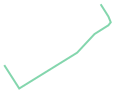

In [714]:
geom = roads_width_final_final[roads_width_final_final['uuid'] == 3159553203].iloc[0]['geometry']
# get_line_azimuth(geom, False)
# Point(geom.geoms[0].coords[1])
geom

In [780]:
f = roads_width_final_final[roads_width_final_final['uuid'] == 3159553203].iloc[0]
# f['geometry'].geoms[0].wkt
# n = find_neighbouring_edges(f, f['v'])
# find_next_road(f, n, f['u'], True)
join_carriageways(f)

     gid             typeweg        uuid  \
183  183  rijbaan lokale weg  1312515038   
223  223  rijbaan lokale weg  1579902025   

                                              geometry  gem_breedte  \
183  MULTILINESTRING ((112187.130 400356.192, 11219...        10.36   
223  MULTILINESTRING ((112194.202 400345.174, 11229...        10.41   

     dev_breedte  min_breedte  max_breedte  oper_breedte  afst_s  ...  bridge  \
183         4.23         6.56        16.91          8.49     0.0  ...     NaN   
223         6.58         5.77        19.26          6.02     0.0  ...     NaN   

     tunnel        service  lanes  ref  width  \
183     NaN  parking_aisle    NaN  NaN    NaN   
223     NaN  parking_aisle    NaN  NaN    NaN   

                                         carriage_ways  \
183  (LINESTRING (112188.9161169869 400357.33883895...   
223  (LINESTRING (112193.3985625663 400346.44596025...   

                                    fixed_carriageways u_next        v_next  
183  (LI

 1312515038,
 101865653]

In [890]:
# 991516825 - dual carriageway neighbouring with single and dual carriagway
# 1911114146 - dual carriageway neighbouring with wider road
# 82 - <1m dual carriageway with adjacent single carriageways
# 2033962726 - It's not working, although it's obvious: this is like this and this is like that.
# 247 - dual carriageway ending in intersections with only single carriageways
# 3057264152 - Slightly over 10°?
next(iter(roads_width_final_final[roads_width_final_final['uuid'] == 4043846082].apply(join_carriageways, axis=1)))[2]

1028620330

In [891]:
roads_width_final_final['fixed_carriageways'], roads_width_final_final['u_next'], roads_width_final_final['v_next'] = zip(*roads_width_final_final.apply(join_carriageways, axis=1))

geopandas.GeoDataFrame(roads_width_final_final[['uuid', 'u', 'v', 'u_next', 'v_next', 'osmid', 'name', 'oneway', 'fixed_carriageways']], geometry='fixed_carriageways', crs='EPSG:28992').to_file('output/fixed_carriageways.geojson', driver='GeoJSON')

**WARNING:** 2495911722 should a `v_next` because it's opposite road assigned it as it's next feature.

## Split carriageways to features

Carriageways should be now converted to individual features:

In [961]:
from shapely.geometry import LineString
import uuid
from cityhash import CityHash32

def create_uuid(f):
    return CityHash32(uuid.uuid4().hex)

def reverse_if_dual(f):
    if f['dual']:
        return LineString(f['geom'].coords[::-1])
    
    return f['geom']

carriageways = roads_width_final_final.copy().rename(columns={
                                                             'geometry': 'axis_geom',
                                                             'fixed_carriageways': 'geom',
                                                             'uuid': 'road_uuid'
                                                             })

carriageways.drop('carriage_ways', 1, inplace=True)
carriageways.drop('gid', 1, inplace=True)

carriageways = geopandas.GeoDataFrame(carriageways, geometry="geom", crs="EPSG:28992")

# Compute "dual" carriageway attribute
carriageways['dual'] = carriageways.apply(lambda f: len(f['geom'].geoms) > 1, axis=1)

# Explode the MultiLineStrings to LineStrings (so duals will become two features)
carriageways = carriageways.explode()

# Make the exploding index a value to define the side of the carriageway: 0 - left, 1 - right
carriageways = carriageways.reset_index(level=-1).rename(columns={'level_1': 'side'})

# Reverse geometries of ex-dual-carriageways
carriageways['geom'] = carriageways.apply(reverse_if_dual, axis=1)

# Create UUIDs
carriageways['uuid'] = carriageways.apply(create_uuid, axis=1)

# Make sure no collisions exist between UUIDs
assert len(pd.unique(carriageways['uuid'])) == len(carriageways['uuid'])

carriageways.drop(['axis_geom', 'geometry_right'], 1).to_file('output/carriageways.geojson', driver='GeoJSON')

## Fix intersections

Given the continuous carriageways, we need to deal with intersections now.

### Trim and split lines at intersections

We need to make sure that lines are splitted (if they "continue" across the interesction) or get trimmed (if that's their end). We determine contiuation or termination by the existence or absense (respectively) of a `u_next`/`v_next` value.

At the end of this step, we have all carriageways as individual `MultiLineStrings`, which contain one or more `LineStrings` that are topologically valid. So, later on we'll have to explode those `MultiLineStrings` to get the individual carriageway segments.

In [970]:
from shapely.ops import substring, split

def get_feature(df, col_name, value):
    return df[df[col_name] == value].iloc[0]

def find_neighbouring_features(G, nodeid, df, uuid_col='uuid', exclude=[]):
    """Returns the road UUIDs of the neighbours of a feature at a given node
    
    G --- The network to lookup
    nodeid --- The id of the node for which to look for neighbours
    df --- The dataframe to find features
    uuid_col --- The name of the column that contains the edge's uuid
    exclude --- A list of uuids to exclude from the returning list
    """
    
    uuids = [a['uuid'] for u, v, a in G.in_edges(nodeid, data=True)] + [a['uuid'] for u, v, a in G.out_edges(nodeid, data=True)]
    
    if isinstance(exclude, list):
        for i in exclude:
            if i in uuids:
                uuids.remove(i)
    else:
        if exclude in uuids:
            uuids.remove(exclude)
    
    return df[df['road_uuid'].isin(uuids)]

def trim_at_intersection(geom, f, nodeid, force_split=False):
    neighbours = find_neighbouring_features(network_graph,
                                            nodeid,
                                            df=carriageways,
                                            uuid_col='road_uuid',
                                            exclude=f['road_uuid'])
    
    # Find the crossing point
    all_lines = shapely.ops.unary_union(neighbours.reset_index()['geom'])
    cross_p = all_lines.intersection(geom)
    
    if cross_p.is_empty:
        return geom
    
    # Split the line according to the other lines
    parts = list(split(geom, all_lines).geoms)
    
    # Cases where we split
    if force_split or len(parts) == 1 or cross_p.type == "MultiPoint":
        next_uuid = f['u_next'] if f['u'] == nodeid else f['v_next']
        # Degenerate case where we need to duplicate the last part of the linestring
        if not np.isnan(next_uuid) and f['dual'] == False and f['oneway'] == "yes" and len(neighbours.groupby('road_uuid')) == 3:            
            next_f = neighbours[neighbours['road_uuid'] == next_uuid].iloc[0]
            if next_f['dual'] == True:
                if f['u'] == nodeid:
                    parts = [reverse_line(parts[0])] + parts
                else:
                    parts = parts + [reverse_line(parts[-1])]
        return MultiLineString(parts)
    
    if f['u'] == nodeid:
        if f['dual'] == True and f['side'] == 0:
            return MultiLineString(parts[:-1])
        else:
            return MultiLineString(parts[1:])
    else:
        if f['dual'] == True and f['side'] == 0:
            return MultiLineString(parts[1:])
        else:
            return MultiLineString(parts[:-1])

def trim_feature(f):
    geom = trim_at_intersection(f['geom'], f, f['u'], not np.isnan(f['u_next']))
    return trim_at_intersection(geom, f, f['v'], not np.isnan(f['v_next']))

carriageways['trimmed'] = carriageways.apply(trim_feature, axis=1)

In [971]:
geopandas.GeoDataFrame(carriageways.drop(['axis_geom', 'geometry_right', 'geom'], 1),
                       geometry="trimmed",
                       crs="EPSG:28992").to_file('output/carriageways_trimmed.geojson', driver='GeoJSON')

### Extend and fix complex intersections

If a carriageway meets a dual road that is continuous, then we need to do certain things:
- In case of no continuation of the carriageway, we need to extend to the end node of the opposite side
- In case of continuation where this is dual and the next road segment is single, we need to make a triangle.

**TODO:** Deal with degenerate case of sideroads. Definition: an intersection of 4 roads, with two being dual and two being single. If the dual are a continuation of ~180° and the two single are <60° we have to move them etc.

In [973]:
def extend_at_intersection(geom, f, nodeid):
    neighbours = find_neighbouring_features(network_graph,
                                            nodeid,
                                            df=carriageways,
                                            uuid_col='road_uuid',
                                            exclude=f['road_uuid'])

    new_lines = list(geom.geoms)
    
    for road_uuid, road in neighbours.groupby('road_uuid'):
#         print(road_uuid)
        if len(road) == 1:
            continue
        
        for uuid, cway in road.set_index('uuid').iterrows():
            if cway['road_uuid'] != f['u_next'] and cway['road_uuid'] != f['v_next'] and geom.intersects(cway['trimmed']):
#                 print("{} intersects {}".format(uuid, f['uuid']))
                
                side = int(not cway['side'])
                
                other_side = road[road['side'] == side].iloc[0]
                
                start_p = geom.intersection(cway['trimmed'])
                
                if start_p.type == "MultiPoint":
                    continue
                
                # We'll use the "geom" because it's more reliable regarding the order of boundaries
                if (other_side['u'] == nodeid) == (side == 1):
#                     print("First point")
                    end_p = other_side['geom'].boundary[0]
                else:
#                     print("Last point")
                    end_p = other_side['geom'].boundary[1]
                
#                 print("End point is {}".format(end_p))
                
                if (f['u'] == nodeid) == (f['side'] == 1):
                    end_p, start_p = (start_p, end_p)
                
                new_lines = new_lines + [LineString((start_p, end_p))]
    
    geom = MultiLineString(new_lines)
    
    return geom

def extend_feature(f):
    geom = f['trimmed']

    if np.isnan(f['u_next']):
        geom = extend_at_intersection(geom, f, f['u'])
    if np.isnan(f['v_next']):
        geom = extend_at_intersection(geom, f, f['v'])
    
    return geom

carriageways['extended'] = carriageways.apply(extend_feature, axis=1)

geopandas.GeoDataFrame(carriageways.drop(['axis_geom', 'geometry_right', 'geom', 'trimmed'], 1),
                       geometry="extended",
                       crs="EPSG:28992").to_file('output/carriageways_extended.geojson', driver='GeoJSON')

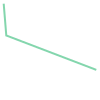

In [928]:
# 121521284
# 3838159254
f = get_feature(carriageways, 'uuid', 1333839479)
# n = find_neighbouring_features(network_graph, 6856770474, carriageways, 'road_uuid', 2890018831)
# for road_uuid, ni in n.groupby("road_uuid"):
#     for i, n in ni.set_index('uuid').iterrows():
#         print(i)
extend_feature(f)

## Several notes and TODOS

1. **(DONE)** Smooth out the carriageways between them:
    - Normal case (two double-carriageways meet), we compute the mid point of the endpoints and join the lines.
    - When a double-carriageway meets a single one, we join with a triangle.
2. Find outliers that are too wide and are a dead-end.
3. Compute the new nodes of the network.

# Introduce flyovers

- What about the width calculation of flyovers? Is there an attribute in BGT about it? Can we compute the width by "isolating" the network and flyover polygon?

# Validation and evaluation

- Make sure we don't have those pedestrian area that are actually roads, but they are inconveniently classified in BGT as `voetpad`.
- We need to rectify our conditions for outliers regarding our decision of carriageway number from width.
- **INVESTIGATION REQUIRED**: If <1m segment is dual carriageway and neighbouring to both a single and a dual carriageway then we should make sure the methodology works.
- Ensure completeless of network (run a simple routing problem)
- Compute decorations like traffic lights
- Potentionally compute more interesting algorithms, e.g. what the best route about de-icing given the width of street (exploiting the semantic surfaces here).